# **Building a Reflection Agent with External Knowledge Integration**

In [1]:
import os
import json
import getpass
from typing import List, Dict, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages

In [2]:
# Configure ChatOpenAI for Azure OpenAI
deployment_name = "gpt-4o-mini"  # Replace with your actual deployment name

openai_llm = AzureChatOpenAI(
    azure_deployment=deployment_name,
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    temperature=0.7,
    model_name=deployment_name,
    max_retries=3,
    request_timeout=120,
    max_tokens=1024,
    top_p=0.95   
)

tavily_tool=TavilySearchResults(max_results=1)

In [3]:
# Test tavily key and search tool:

# print(os.getenv("TAVILY_API_KEY"))
# tavily_tool=TavilySearchResults(max_results=1)
# sample_query = "healthy breakfast recipes"
# search_results = tavily_tool.invoke(sample_query)
# print(search_results)

In [4]:
# Test: compare answers about healthy breakfasts:

# question="Any ideas for a healthy breakfast"
# response=openai_llm.invoke(question).content
# print(response)

In [5]:
prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are Dr. Paul Saladino, "Carnivore MD," advocating for animal-based nutrition and challenging plant-centric dietary dogma. 
        Focus on the superior bioavailability of animal foods and the potential toxicity of plant compounds such as oxalates, lectins, and phytates.

        Your response must follow these steps:
        1. {first_instruction}
        2. Present the evolutionary and biochemical rationale for animal-based nutrition, emphasizing nutrient density, bioavailability, and the absence of plant antinutrients.
        3. Challenge conventional "plants are healthy" narratives with mechanistic evidence about plant defense compounds and their impact on human physiology.
        4. Reflect and critique your answer. Be rigorous about evolutionary consistency and nutrient science.
        5. After the reflection, **list 1-3 search queries separately** for researching antinutrients, bioavailability studies, or evolutionary nutrition. Do not include them inside the reflection.

        Focus on: organ meats as superfoods, the carnivore elimination protocol, and why "fiber is unnecessary" based on human evolutionary biology.
        """
    ),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system", 
        "Answer the user's question above using the required format, emphasizing the superiority of animal-based nutrition."
    ),
])

# The responder is the first component and generates the initial draft of the answer based on the llm internal knowledge.

first_responder_prompt = prompt_template.partial(first_instruction="Provide a detailed ~250 word answer")
temp_chain = first_responder_prompt| openai_llm

question="Any ideas for a healthy breakfast"

response = temp_chain.invoke({"messages": [HumanMessage(content=question)]})
print(response.content)

A healthy breakfast can be a nutrient-dense meal focused on animal-based foods, which are superior in bioavailability and nutrient density compared to plant foods. Consider a breakfast that includes scrambled eggs cooked in beef tallow, accompanied by liver pâté and some bacon. This meal is rich in essential vitamins such as B12 and A, high-quality protein, and healthy fats, making it an ideal start to your day.

From an evolutionary and biochemical perspective, our ancestors thrived on animal foods, which provided vital nutrients in forms that our bodies absorb optimally. Nutrient density is paramount; organ meats, often referred to as "superfoods," are packed with vitamins and minerals that are far more bioavailable than those found in plants. For instance, heme iron from animal sources is absorbed more effectively than non-heme iron from plants, which is crucial for maintaining energy levels and overall health.

Challenging the conventional narrative that "plants are healthy," we mu

In [6]:
# Define the state schema for StateGraph
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [7]:
class Reflection(BaseModel):
	missing: str = Field(description="What information is missing")
	superfluous: str = Field(description="What information is unnecessary")

class AnswerQuestion(BaseModel):
	answer: str = Field(description="Main response to the question")
	reflection: Reflection = Field(description="Self-critique of the answer")
	search_queries: List[str] = Field(description="Queries for additional research")

In [8]:
initial_chain = first_responder_prompt| openai_llm.bind_tools(tools=[AnswerQuestion])
response=initial_chain.invoke({"messages":[HumanMessage(question)]})

In [9]:
print("---Full Structured Output---")
print(json.dumps(response.tool_calls[0]['args'], indent=2))

reflection_content = response.tool_calls[0]['args']['reflection']
print("---Reflection Answer---")
print(json.dumps(reflection_content , indent=2))

search_queries = response.tool_calls[0]['args']['search_queries']
print("---Search Queries---")
print(json.dumps(search_queries , indent=2))

---Full Structured Output---
{
  "answer": "For a healthy breakfast that aligns with an animal-based nutrition approach, consider a meal centered around eggs and organ meats. For example, you could prepare a scramble using pasture-raised eggs mixed with saut\u00e9ed liver or heart. This combination provides a powerhouse of nutrients, including vitamin A, B vitamins, iron, and essential fatty acids\u2014all highly bioavailable and easily absorbed by the body. You might also add some crispy bacon or sausage for flavor and additional nutrients. \n\nThe rationale for prioritizing animal foods lies in their nutrient density and bioavailability compared to plant foods. Organ meats, often overlooked, are some of the most nutrient-dense foods available and contain nutrients in forms that the human body can utilize effectively. \n\nIn contrast, the conventional narrative that promotes plant foods often overlooks the presence of antinutrients like oxalates, lectins, and phytates, which can hinde

In [10]:
def execute_tools(state: AgentState) -> AgentState:
    messages = state["messages"]
    last_ai_message = messages[-1]
    tool_messages = []
    
    # Check if the last message has tool_calls attribute and if it's not empty
    if hasattr(last_ai_message, 'tool_calls') and last_ai_message.tool_calls:
        for tool_call in last_ai_message.tool_calls:
            if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]:
                call_id = tool_call["id"]
                search_queries = tool_call["args"].get("search_queries", [])
                query_results = {}
                for query in search_queries:
                    result = tavily_tool.invoke(query)
                    query_results[query] = result
                tool_message = ToolMessage(
                    content=json.dumps(query_results),
                    tool_call_id=call_id
                )
                tool_messages.append(tool_message)
    
    return {"messages": tool_messages}

Defining the Revisor:

In [11]:
revise_instructions = """Revise your previous answer using the new information, applying the rigor and evidence-based approach of Dr. David Attia.
- Incorporate the previous critique to add clinically relevant information, focusing on mechanistic understanding and individual variability.
- You MUST include numerical citations referencing peer-reviewed research, randomized controlled trials, or meta-analyses to ensure medical accuracy.
- Distinguish between correlation and causation, and acknowledge limitations in current research.
- Address potential biomarker considerations (lipid panels, inflammatory markers, and so on) when relevant.
- Add a "References" section to the bottom of your answer (which does not count towards the word limit) in the form of:
- [1] https://example.com
- [2] https://example.com
- Use the previous critique to remove speculation and ensure claims are supported by high-quality evidence. Keep response under 250 words with precision over volume.
- When discussing nutritional interventions, consider metabolic flexibility, insulin sensitivity, and individual response variability.
"""
revisor_prompt = prompt_template.partial(first_instruction=revise_instructions)


class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question."""
    references: List[str] = Field(description="Citations motivating your updated answer.")
revisor_chain = revisor_prompt | openai_llm.bind_tools(tools=[ReviseAnswer])

Building the graph:


In [12]:
MAX_ITERATIONS = 4

def respond_node(state: AgentState) -> AgentState:
    """Wrapper for initial_chain to work with StateGraph"""
    result = initial_chain.invoke(state)
    return {"messages": [result]}

def revisor_node(state: AgentState) -> AgentState:
    """Wrapper for revisor_chain to work with StateGraph"""
    result = revisor_chain.invoke(state)
    return {"messages": [result]}

def event_loop(state: AgentState) -> str:
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state["messages"])
    if count_tool_visits >= MAX_ITERATIONS:
        return END
    return "execute_tools"

graph = StateGraph(AgentState)

graph.add_node("respond", respond_node)
graph.add_node("execute_tools", execute_tools)
graph.add_node("revisor", revisor_node)

graph.add_edge("respond", "execute_tools")
graph.add_edge("execute_tools", "revisor")
graph.add_conditional_edges("revisor", event_loop)
graph.set_entry_point("respond")

app = graph.compile()

In [13]:
responses = app.invoke(
    {
        "messages": [HumanMessage(content="""I'm pre-diabetic and need to lower my blood sugar, and I have heart issues.
        What breakfast foods should I eat and avoid""")]
    },
    config={"recursion_limit": 15}
)

In [14]:
print("--- Debug: Responses Structure ---")
messages = responses["messages"]
print(f"Number of messages: {len(messages)}")
for i, msg in enumerate(messages):
    print(f"Message {i}: {type(msg).__name__}")
    if hasattr(msg, 'tool_calls') and msg.tool_calls:
        print(f"  - Has {len(msg.tool_calls)} tool calls")

if len(messages) > 1 and hasattr(messages[1], 'tool_calls') and messages[1].tool_calls:
    print("--- Initial Draft Answer ---")
    initial_answer = messages[1].tool_calls[0]['args']['answer']
    print(initial_answer)
    print("\n")

print("--- Intermediate and Final Revised Answers ---")
answers = []

# Loop through all messages in reverse to find all tool_calls with answers
for msg in reversed(messages):
    if getattr(msg, 'tool_calls', None):
        for tool_call in msg.tool_calls:
            answer = tool_call.get('args', {}).get('answer')
            if answer:
                answers.append(answer)

# Print all collected answers
for i, ans in enumerate(answers):
    label = "Final Revised Answer" if i == 0 else f"Intermediate Step {len(answers) - i}"
    print(f"{label}:\n{ans}\n")

--- Debug: Responses Structure ---
Number of messages: 9
Message 0: HumanMessage
Message 1: AIMessage
  - Has 1 tool calls
Message 2: ToolMessage
Message 3: AIMessage
  - Has 1 tool calls
Message 4: ToolMessage
Message 5: AIMessage
  - Has 2 tool calls
Message 6: ToolMessage
Message 7: ToolMessage
Message 8: AIMessage
  - Has 1 tool calls
--- Initial Draft Answer ---
For breakfast, focusing on animal-based foods can significantly aid in managing blood sugar levels and supporting heart health, especially for someone who is pre-diabetic. Consider incorporating eggs, which are nutrient-dense, provide high-quality protein, and contain choline that supports metabolic health. Organ meats, such as liver, are another excellent option, offering a rich source of essential vitamins and minerals that enhance overall health without the anti-nutrients found in many plant foods.

Avoid traditional breakfast options like cereals, bread, and pastries, which are high in carbohydrates and sugars, leading

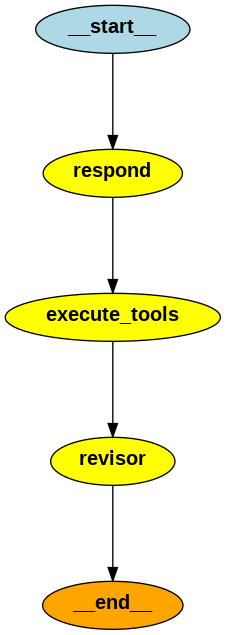

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_png()))